In [1]:
import time
import pandas as pd
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from functools import partial
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import optimizers
import tensorflow_datasets as tfds

assert tf.__version__ >= "2.0"

In [2]:
# 8.22 결과를 그래프로 나타내기 
def show_plot(history):
  acc = history.history["accuracy"]
  val_acc = history.history["val_accuracy"]
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, "bo", label = "Training accuracy")
  plt.plot(epochs, val_acc, "b", label = "Validation accuracy")
  plt.title("Training and validation accuracy")
  plt.legend()
  plt.figure()

  plt.plot(epochs, loss , "bo", label = "Training loss")
  plt.plot(epochs, val_loss, "b", label = "Validation_loss")
  plt.title("Training and validation loss")
  plt.legend()
  plt.show()

In [3]:
# 8.26 테스트 세트에서 모델 평가하기
def model_test(MODEL_PATH, test_set):
  test_model = keras.models.load_model(MODEL_PATH)
  test_loss, test_acc = test_model.evaluate(test_set)
  print(f"테스트 정확도 : {test_acc*100:.3f}%")
  return test_loss, test_acc

# 1. Rock_paper_scissors

#### trainin / validation / test set 분리

In [4]:
dataset, info = tfds.load("rock_paper_scissors", as_supervised=True, with_info=True)
class_names = info.features["label"].names # ["rock", "paper", "scissors"]
n_classes = info.features["label"].num_classes # 3
dataset_size = info.splits["train"].num_examples # 2520

test_set_raw, valid_set_raw, train_set_raw = tfds.load("rock_paper_scissors", 
                                                       as_supervised=True, 
                                                       split=["train[:10%]","train[10%:25%]", "train[25%:]"])


def preprocess(image, label):
  resized_image = tf.image.resize(image, [224, 224])
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label


batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

rsp_results = pd.DataFrame(columns = ['test_acc', 'test_loss', 'pred_time'], index = ['Xception_without_data_augmentation', 'Xception_with_data_augmentation', 'Xception_change_hp'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete0W4BGJ/rock_paper_scissors-train.tfrec…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/3.0.0.incomplete0W4BGJ/rock_paper_scissors-test.tfreco…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.


```label names``` = ['rock', 'paper', 'scissors']  
```num_classes``` = 3   
```
FeaturesDict({
    'image': Image(shape=(300, 300, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
})
```

```
info.splits
>>> {Split('train'): <SplitInfo num_examples=2520, num_shards=2>,
 Split('test'): <SplitInfo num_examples=372, num_shards=1>}
 ```


- **데이터 확인**

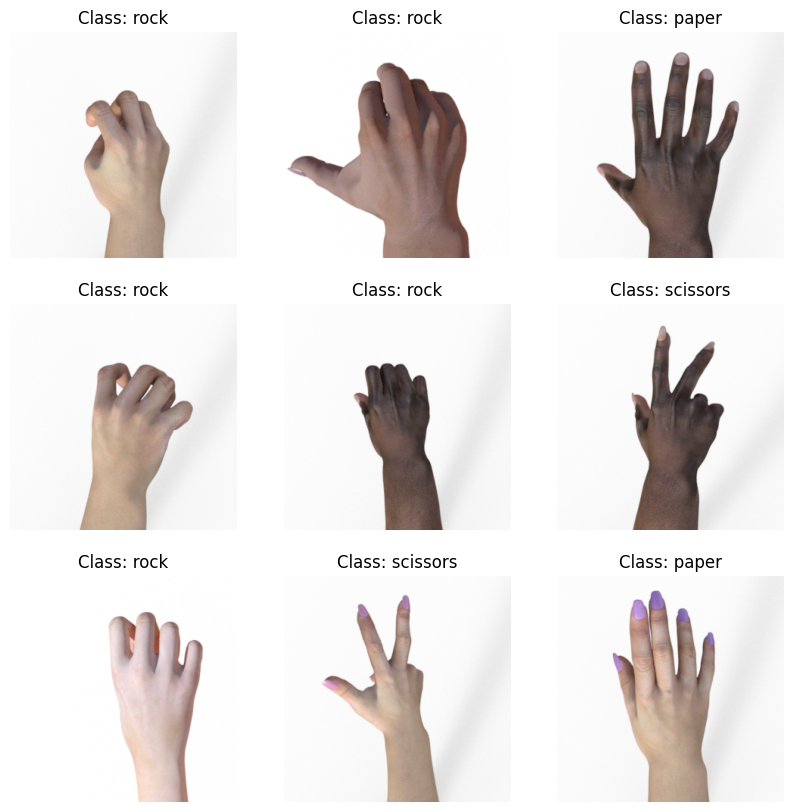

In [5]:
plt.figure(figsize=(10, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

## (1) Data augmentation 미적용

83683744/83683744 [==============================] - 4s 0us/step
Epoch 1/40
59/59 [==============================] - 32s 103ms/step - loss: 0.2048 - accuracy: 0.9343 - val_loss: 0.2347 - val_accuracy: 0.9176
Epoch 2/40
59/59 [==============================] - 5s 85ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss: 0.0363 - val_accuracy: 0.9943
Epoch 3/40
59/59 [==============================] - 5s 85ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 0.9972
Epoch 4/40
59/59 [==============================] - 5s 85ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 2.9339e-04 - val_accuracy: 1.0000
Epoch 5/40
59/59 [==============================] - 5s 85ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.7031e-04 - val_accuracy: 1.0000
Epoch 6/40
59/59 [==============================] - 5s 85ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 1.5695e-04 - val_accuracy: 1.0000
Epoch 7/40
59/59 [==============================] - 4s 75ms/step - loss: 6.

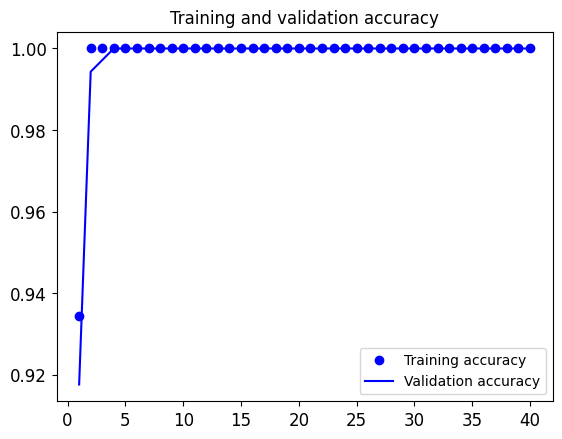

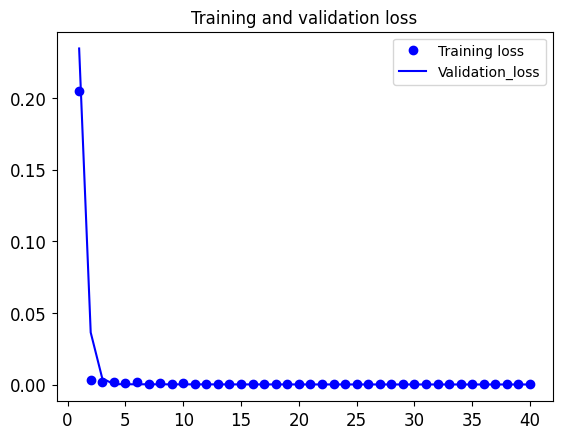

8/8 [==============================] - 1s 45ms/step - loss: 2.3593e-05 - accuracy: 1.0000
테스트 정확도 : 100.000%
8/8 [==============================] - 1s 14ms/step


In [6]:
base_model= keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

# fine-tuning
for layer in base_model.layers:
   layer.trainable = True

MODEL_SAVE_PATH = "Xception_without_data_augmentation.keras"
EPOCHS = 40 

early_stopping_cb=keras.callbacks.EarlyStopping(patience = 10) # Early_Stopping
callbacks = [
    early_stopping_cb,
    keras.callbacks.ModelCheckpoint( # Checkpoint
        filepath = MODEL_SAVE_PATH,
        save_best_only = True,
        monitor = "val_loss"
    )
]
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, weight_decay=0.001)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics=["accuracy"])

model1_history = model.fit(train_set, epochs=EPOCHS, 
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = callbacks
                    )

show_plot(model1_history) # history graph
model1_test_loss, model1_test_acc = model_test(MODEL_SAVE_PATH, test_set) # test dataset에 대한 evaluation 결과

start = time.time()
model.predict(test_set)
end = time.time()
model1_predict_time = end - start # prediction_time

rsp_results.loc["Xception_without_data_augmentation"] = (model1_test_acc, model1_test_loss, model1_predict_time) 

## (2) Data augmentation 적용

In [7]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])


def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label


# 데이터 증강을 포함한 전처리 함수 정의
def augment_preprocess(image, label):
    augmented_image = data_augmentation(image)
    resized_image = tf.image.resize(augmented_image, [224, 224])
    normalized_image = resized_image / 255.0
    return normalized_image, label

data_augmentation = keras.Sequential( # data augmentation
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

- **augmentation 결과 확인**

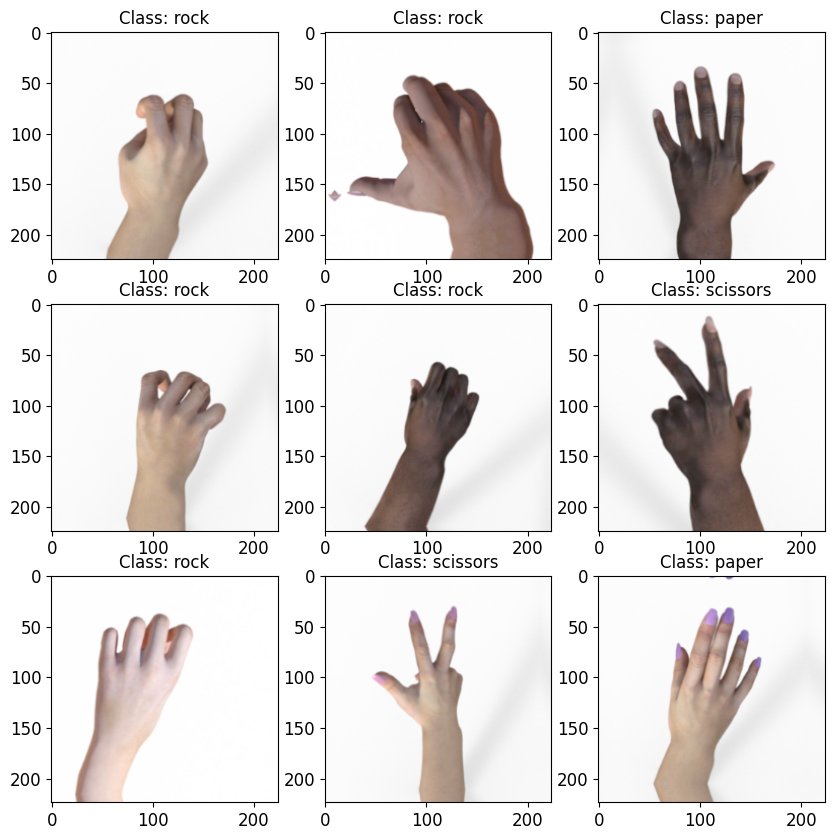

In [8]:
# augmentation 결과 확인 
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(augment_preprocess)).batch(batch_size).prefetch(1)
train_set = train_set_raw.map(augment_preprocess)

plt.figure(figsize=(10, 10))
index = 0
for image, label in train_set.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))

plt.show()

Epoch 1/40
59/59 [==============================] - 25s 104ms/step - loss: 0.2442 - accuracy: 0.8978 - val_loss: 0.3092 - val_accuracy: 0.8835
Epoch 2/40
59/59 [==============================] - 5s 89ms/step - loss: 0.0147 - accuracy: 0.9968 - val_loss: 0.0289 - val_accuracy: 0.9943
Epoch 3/40
59/59 [==============================] - 5s 88ms/step - loss: 0.0074 - accuracy: 0.9979 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 4/40
59/59 [==============================] - 5s 78ms/step - loss: 0.0051 - accuracy: 0.9984 - val_loss: 0.0481 - val_accuracy: 0.9716
Epoch 5/40
59/59 [==============================] - 5s 78ms/step - loss: 0.0091 - accuracy: 0.9974 - val_loss: 0.0250 - val_accuracy: 0.9886
Epoch 6/40
59/59 [==============================] - 5s 78ms/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 7/40
59/59 [==============================] - 5s 89ms/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 4.3201e-04 - val_accuracy: 1.0000
Epoch 8

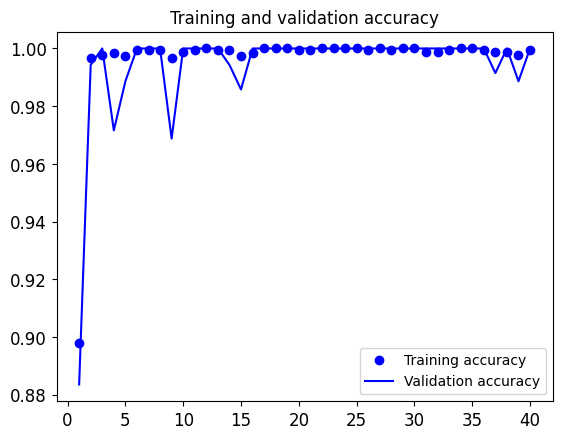

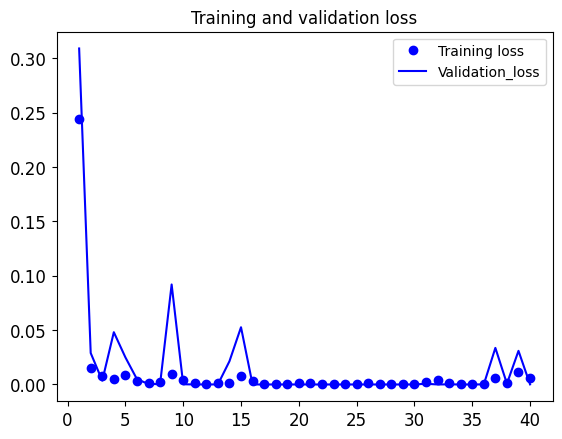

8/8 [==============================] - 1s 46ms/step - loss: 2.2219e-06 - accuracy: 1.0000
테스트 정확도 : 100.000%
8/8 [==============================] - 1s 15ms/step


In [9]:
# 모델 적용을 위해 Input_size 수정한 ver
def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    resized_image = tf.squeeze(resized_image)  # 차원 축소
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

# 데이터 증강을 포함한 전처리 함수 정의 (모델 적용을 위해 Input_size 수정한 ver)
def augment_preprocess(image, label):
    augmented_image = data_augmentation(image)
    resized_image = tf.image.resize(augmented_image, [224, 224])
    normalized_image = resized_image / 255.0
    return normalized_image, label

data_augmentation = keras.Sequential(
    [
        layers.Conv2D(3, 3, input_shape=(224, 224, 3)),  # 입력 형태 설정
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

base_model= keras.applications.xception.Xception(weights="imagenet", include_top=False)
# fine-tuning
for layer in base_model.layers:
   layer.trainable = True

# inputs = keras.Input(shape=(None, None, 3)) 
inputs = keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs) # data augmentation 적용
x = keras.applications.xception.preprocess_input(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_classes, activation="softmax")(x)  


model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, weight_decay=0.001)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics=["accuracy"])

MODEL_SAVE_PATH = "Xception_with_data_augmentation.keras"
EPOCHS = 40

early_stopping_cb=keras.callbacks.EarlyStopping(patience = 10) # Early_Stopping
callbacks = [
    early_stopping_cb, # Early_Stopping
    keras.callbacks.ModelCheckpoint( # Checkpoint
        filepath = MODEL_SAVE_PATH,
        save_best_only = True,
        monitor = "val_loss"
    )
]

model2_history = model.fit(train_set, epochs=EPOCHS, 
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = callbacks
                    )

show_plot(model2_history) # history graph
model2_test_loss, model2_test_acc = model_test(MODEL_SAVE_PATH, test_set) # test dataset에 대한 evaluation 결과

start = time.time()
model.predict(test_set)
end = time.time()
model2_predict_time = end - start # prediction_time

rsp_results.loc["Xception_with_data_augmentation"] = (model2_test_acc, model2_test_loss, model2_predict_time) 

## (3) 1-(2)에서 hyper parameter 변형

- 기존
  - epochs = 40
  - learning_rate = 0.01
  - batch_size = 32

Epoch 1/5
59/59 [==============================] - 21s 103ms/step - loss: 7.0407e-04 - accuracy: 1.0000 - val_loss: 2.5819e-06 - val_accuracy: 1.0000
Epoch 2/5
59/59 [==============================] - 5s 79ms/step - loss: 0.2439 - accuracy: 0.9142 - val_loss: 55515.1250 - val_accuracy: 0.3125
Epoch 3/5
59/59 [==============================] - 5s 79ms/step - loss: 0.2088 - accuracy: 0.9296 - val_loss: 100.5803 - val_accuracy: 0.5256
Epoch 4/5
59/59 [==============================] - 5s 79ms/step - loss: 0.1102 - accuracy: 0.9693 - val_loss: 3.3459 - val_accuracy: 0.8239
Epoch 5/5
59/59 [==============================] - 5s 79ms/step - loss: 0.0309 - accuracy: 0.9899 - val_loss: 0.1604 - val_accuracy: 0.9545


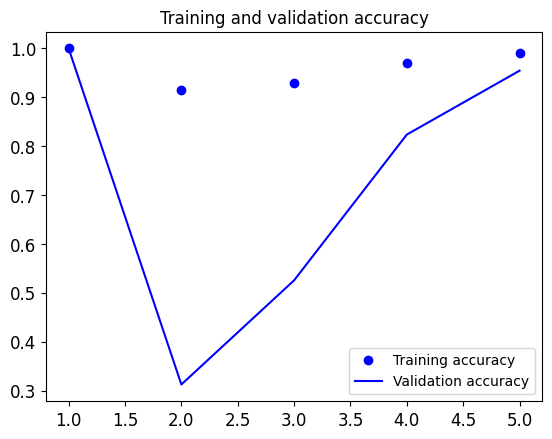

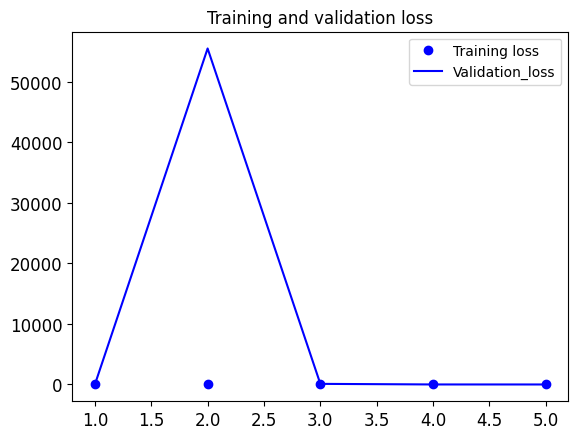

8/8 [==============================] - 1s 20ms/step - loss: 3.5710e-06 - accuracy: 1.0000
테스트 정확도 : 100.000%


In [10]:
# 하이퍼 파라미터 변형 (learning_rate, EPOCHS)
EPOCHS = 5
lr = 0.1

train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

base_model= keras.applications.xception.Xception(weights="imagenet", include_top=False)
# 마지막에서 네번째 층까지 모든 층 동결하기 
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate= lr, momentum=0.9, nesterov=True, weight_decay=0.001)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics=["accuracy"])

MODEL_SAVE_PATH = "Xception_Xception_change_hyperparameters.keras"

callbacks = [
    # early_stopping_cb, # Early_Stopping
    keras.callbacks.ModelCheckpoint( # Checkpoint
        filepath = MODEL_SAVE_PATH,
        save_best_only = True,
        monitor = "val_loss"
    )
]

model3_history = model.fit(train_set, epochs=EPOCHS, 
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = callbacks
                    )

show_plot(model3_history) # history graph
model3_test_loss, model3_test_acc = model_test(MODEL_SAVE_PATH, test_set) # test dataset에 대한 evaluation 결과

Epoch 1/5
59/59 [==============================] - 21s 105ms/step - loss: 0.0206 - accuracy: 0.9958 - val_loss: 0.0210 - val_accuracy: 0.9972
Epoch 2/5
59/59 [==============================] - 5s 89ms/step - loss: 0.0137 - accuracy: 0.9974 - val_loss: 0.0118 - val_accuracy: 1.0000
Epoch 3/5
59/59 [==============================] - 5s 89ms/step - loss: 0.0248 - accuracy: 0.9963 - val_loss: 0.0059 - val_accuracy: 1.0000
Epoch 4/5
59/59 [==============================] - 5s 89ms/step - loss: 0.0229 - accuracy: 0.9968 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 5/5
59/59 [==============================] - 5s 89ms/step - loss: 0.0119 - accuracy: 0.9968 - val_loss: 0.0023 - val_accuracy: 1.0000


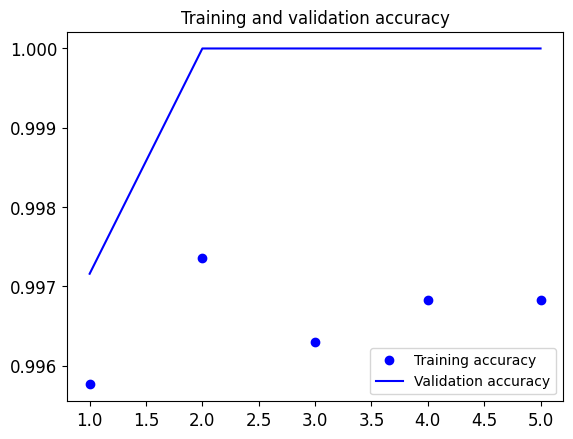

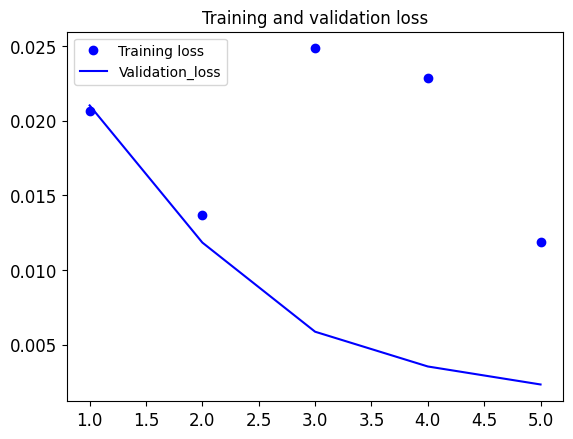

8/8 [==============================] - 1s 19ms/step - loss: 0.0022 - accuracy: 1.0000
테스트 정확도 : 100.000%


In [11]:
# 하이퍼 파라미터 변형 (learning_rate, EPOCHS)
EPOCHS = 5
lr = 1e-5

train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

base_model= keras.applications.xception.Xception(weights="imagenet", include_top=False)
# 마지막에서 네번째 층까지 모든 층 동결하기 
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate= lr, momentum=0.9, nesterov=True, weight_decay=0.001)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics=["accuracy"])

MODEL_SAVE_PATH = "Xception_Xception_change_hyperparameters.keras"

callbacks = [
    # early_stopping_cb, # Early_Stopping
    keras.callbacks.ModelCheckpoint( # Checkpoint
        filepath = MODEL_SAVE_PATH,
        save_best_only = True,
        monitor = "val_loss"
    )
]

model3_history = model.fit(train_set, epochs=EPOCHS, 
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = callbacks
                    )

show_plot(model3_history) # history graph
model3_test_loss, model3_test_acc = model_test(MODEL_SAVE_PATH,test_set) # test dataset에 대한 evaluation 결과

Epoch 1/40
59/59 [==============================] - 21s 104ms/step - loss: 0.0115 - accuracy: 0.9974 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 2/40
59/59 [==============================] - 5s 90ms/step - loss: 0.0210 - accuracy: 0.9952 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 3/40
59/59 [==============================] - 5s 89ms/step - loss: 0.0235 - accuracy: 0.9958 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 4/40
59/59 [==============================] - 5s 89ms/step - loss: 0.0162 - accuracy: 0.9963 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 5/40
59/59 [==============================] - 5s 79ms/step - loss: 0.0133 - accuracy: 0.9963 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 6/40
59/59 [==============================] - 5s 78ms/step - loss: 0.0126 - accuracy: 0.9968 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 7/40
59/59 [==============================] - 5s 79ms/step - loss: 0.0212 - accuracy: 0.9947 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 8/40


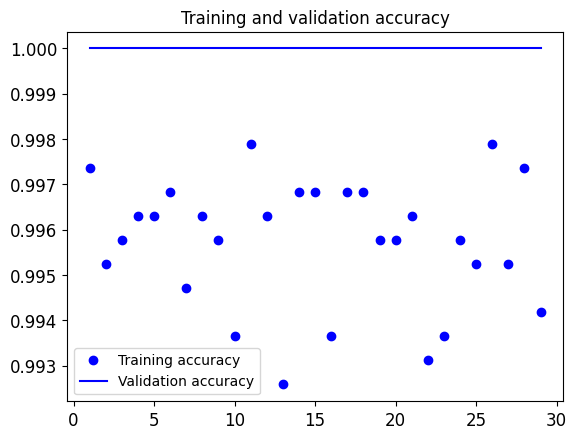

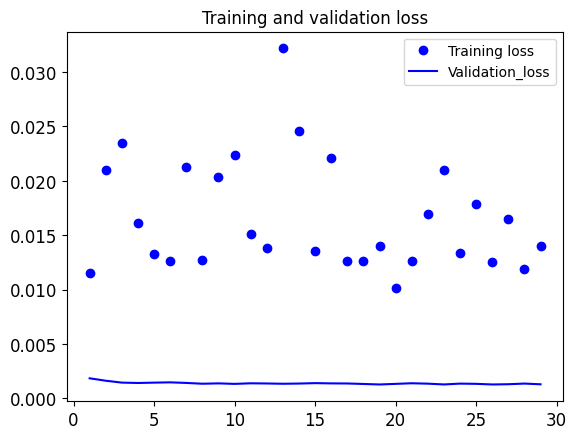

8/8 [==============================] - 1s 19ms/step - loss: 0.0011 - accuracy: 1.0000
테스트 정확도 : 100.000%
8/8 [==============================] - 1s 15ms/step


In [12]:
# 하이퍼 파라미터 변형 (learning_rate, EPOCHS)
EPOCHS = 40
lr = 1e-5

train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

base_model= keras.applications.xception.Xception(weights="imagenet", include_top=False)
# 마지막에서 네번째 층까지 모든 층 동결하기 
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate= lr, momentum=0.9, nesterov=True, weight_decay=0.001)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics=["accuracy"])

MODEL_SAVE_PATH = "Xception_Xception_change_hyperparameters.keras"

early_stopping_cb=keras.callbacks.EarlyStopping(patience = 10) # Early_Stopping
callbacks = [
    early_stopping_cb, # Early_Stopping
    keras.callbacks.ModelCheckpoint( # Checkpoint
        filepath = MODEL_SAVE_PATH,
        save_best_only = True,
        monitor = "val_loss"
    )
]

model3_history = model.fit(train_set, epochs=EPOCHS, 
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = callbacks
                    )

show_plot(model3_history) # history graph
model3_test_loss, model3_test_acc = model_test(MODEL_SAVE_PATH,test_set) # test dataset에 대한 evaluation 결과

start = time.time()
model.predict(test_set)
end = time.time()
model3_predict_time = end - start # prediction_time

rsp_results.loc["Xception_change_hp"] = (model3_test_acc, model3_test_loss, model3_predict_time) 

****

## 각 evaluation 결과

In [13]:
rsp_results

,test_acc,test_loss,pred_time
Xception_without_data_augmentation,1.0,0.000024,0.881503
Xception_with_data_augmentation,1.0,0.000002,0.901207
Xception_change_hp,1.0,0.001107,0.900529


[Text(0, 0, 'Xception_without_data_augmentation'),
 Text(1, 0, 'Xception_with_data_augmentation'),
 Text(2, 0, 'Xception_change_hp')]

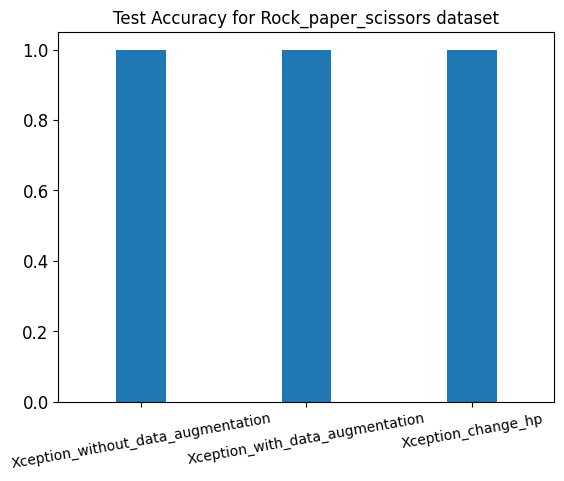

In [14]:
models = list(rsp_results.index)
test_accs = list(rsp_results["test_acc"])
plt.bar(range(len((models))), test_accs, width = 0.3)

plt.xlim(-0.5, 2.5)
plt.title('Test Accuracy for Rock_paper_scissors dataset')

ax = plt.subplot()
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(models, fontsize = 10, rotation = 10)

[Text(0, 0, 'Xception_without_data_augmentation'),
 Text(1, 0, 'Xception_with_data_augmentation'),
 Text(2, 0, 'Xception_change_hp')]

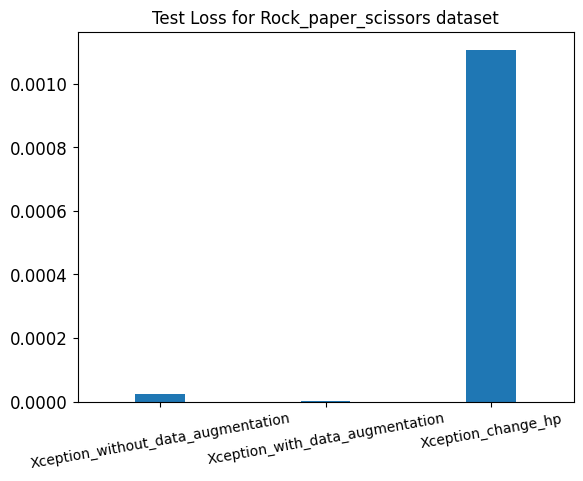

In [15]:
test_losss = list(rsp_results["test_loss"])
plt.bar(range(len((models))), test_losss, width = 0.3)

plt.xlim(-0.5, 2.5)
plt.title('Test Loss for Rock_paper_scissors dataset')

ax = plt.subplot()
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(models, fontsize = 10, rotation = 10)

[Text(0, 0, 'Xception_without_data_augmentation'),
 Text(1, 0, 'Xception_with_data_augmentation'),
 Text(2, 0, 'Xception_change_hp')]

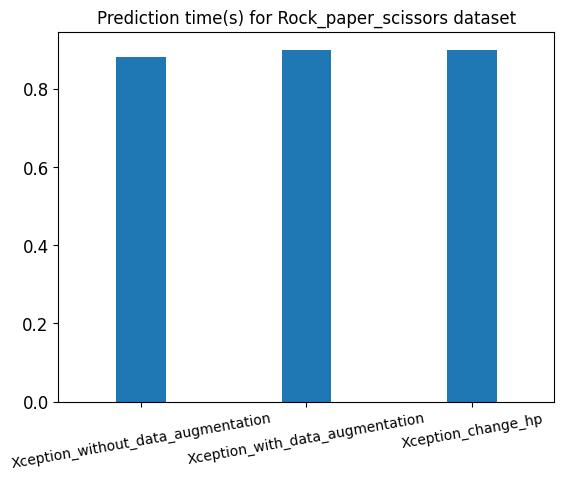

In [16]:
pred_times = list(rsp_results["pred_time"])
plt.bar(range(len((models))), pred_times, width = 0.3)

plt.xlim(-0.5, 2.5)
plt.title('Prediction time(s) for Rock_paper_scissors dataset')

ax = plt.subplot()
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(models, fontsize = 10, rotation = 10)

***

# 2. Eurosat

In [17]:
dataset, info = tfds.load("eurosat/rgb", as_supervised=True, with_info=True)
class_names = info.features["label"].names 
n_classes = info.features["label"].num_classes # 10
dataset_size = info.splits["train"].num_examples # 27000

test_set_raw, valid_set_raw, train_set_raw = tfds.load("eurosat/rgb", 
                                                       as_supervised=True, 
                                                       split=["train[:10%]","train[10%:25%]", "train[25%:]"])


def preprocess(image, label):
  resized_image = tf.image.resize(image, [224, 224])
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label


batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

eurosat_results = pd.DataFrame(columns = ['test_acc', 'test_loss', 'pred_time'], index = ['Xception_without_data_augmentation', 'Xception_with_data_augmentation', 'Xception_change_hp'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/2.0.0.incomplete7S400Q/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


```label names``` = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']    

```num_classes``` = 10  
```
FeaturesDict({
    'filename': Text(shape=(), dtype=string),
    'image': Image(shape=(64, 64, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
})
```  
```
info.splits  
>>> {Split('train'): <SplitInfo num_examples=27000, num_shards=1>}
```

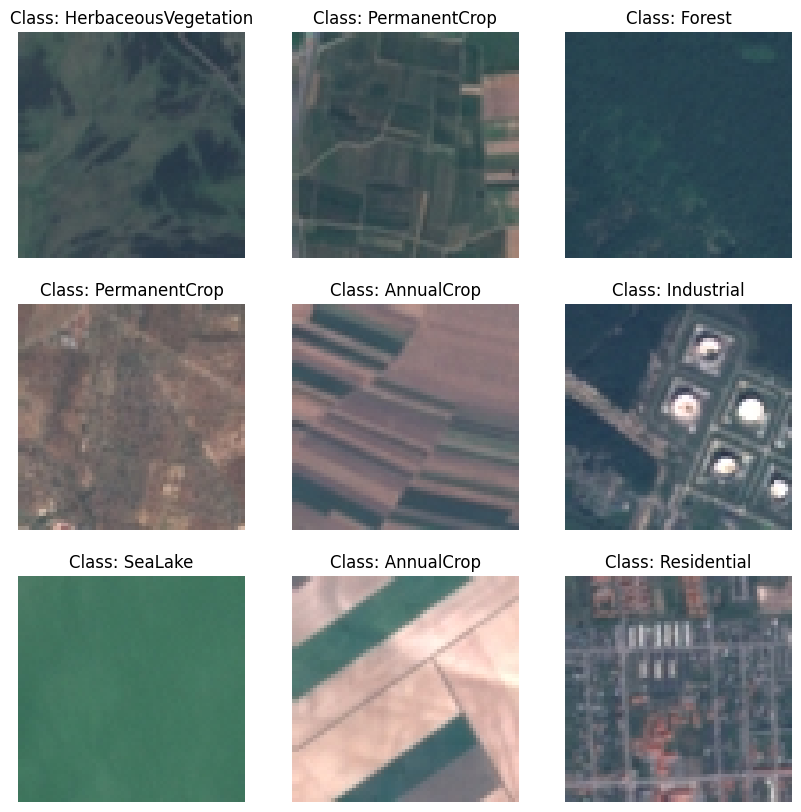

In [18]:
plt.figure(figsize=(10, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

## (1) Data augmentation 미적용

Epoch 1/40
632/632 [==============================] - 63s 77ms/step - loss: 0.2457 - accuracy: 0.9231 - val_loss: 0.1430 - val_accuracy: 0.9576
Epoch 2/40
632/632 [==============================] - 48s 75ms/step - loss: 0.0630 - accuracy: 0.9792 - val_loss: 0.0611 - val_accuracy: 0.9807
Epoch 3/40
632/632 [==============================] - 47s 74ms/step - loss: 0.0266 - accuracy: 0.9917 - val_loss: 0.0677 - val_accuracy: 0.9779
Epoch 4/40
632/632 [==============================] - 48s 75ms/step - loss: 0.0195 - accuracy: 0.9936 - val_loss: 0.0535 - val_accuracy: 0.9836
Epoch 5/40
632/632 [==============================] - 48s 75ms/step - loss: 0.0144 - accuracy: 0.9958 - val_loss: 0.0459 - val_accuracy: 0.9874
Epoch 6/40
632/632 [==============================] - 47s 74ms/step - loss: 0.0096 - accuracy: 0.9974 - val_loss: 0.0568 - val_accuracy: 0.9829
Epoch 7/40
632/632 [==============================] - 47s 74ms/step - loss: 0.0076 - accuracy: 0.9980 - val_loss: 0.0636 - val_accuracy:

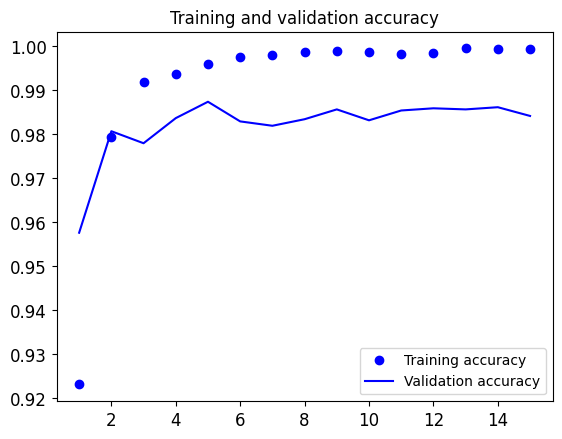

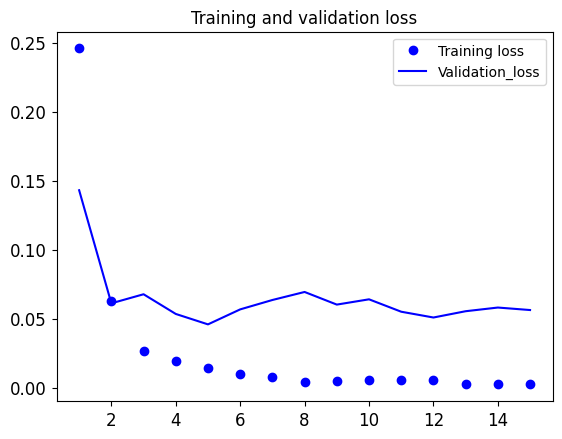

85/85 [==============================] - 2s 18ms/step - loss: 0.0674 - accuracy: 0.9815
테스트 정확도 : 98.148%
85/85 [==============================] - 3s 14ms/step


In [19]:
base_model= keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

# fine-tuning
for layer in base_model.layers:
   layer.trainable = True

MODEL_SAVE_PATH = "Xception_without_data_augmentation.keras"
EPOCHS = 40 

early_stopping_cb=keras.callbacks.EarlyStopping(patience = 10) # Early_Stopping
callbacks = [
    early_stopping_cb,
    keras.callbacks.ModelCheckpoint( # Checkpoint
        filepath = MODEL_SAVE_PATH,
        save_best_only = True,
        monitor = "val_loss"
    )
]
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, weight_decay=0.001)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics=["accuracy"])

model1_history = model.fit(train_set, epochs=EPOCHS, 
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = callbacks
                    )

show_plot(model1_history) # history graph
model1_test_loss, model1_test_acc = model_test(MODEL_SAVE_PATH, test_set) # test dataset에 대한 evaluation 결과

start = time.time()
model.predict(test_set)
end = time.time()
model1_predict_time = end - start # prediction_time

eurosat_results.loc["Xception_without_data_augmentation"] = (model1_test_acc, model1_test_loss, model1_predict_time) 

## (2) Data augmentation 적용

In [20]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])


def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label


# 데이터 증강을 포함한 전처리 함수 정의
def augment_preprocess(image, label):
    augmented_image = data_augmentation(image)
    resized_image = tf.image.resize(augmented_image, [224, 224])
    normalized_image = resized_image / 255.0
    return normalized_image, label

data_augmentation = keras.Sequential( # data augmentation
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

- **augmentation 결과 확인**

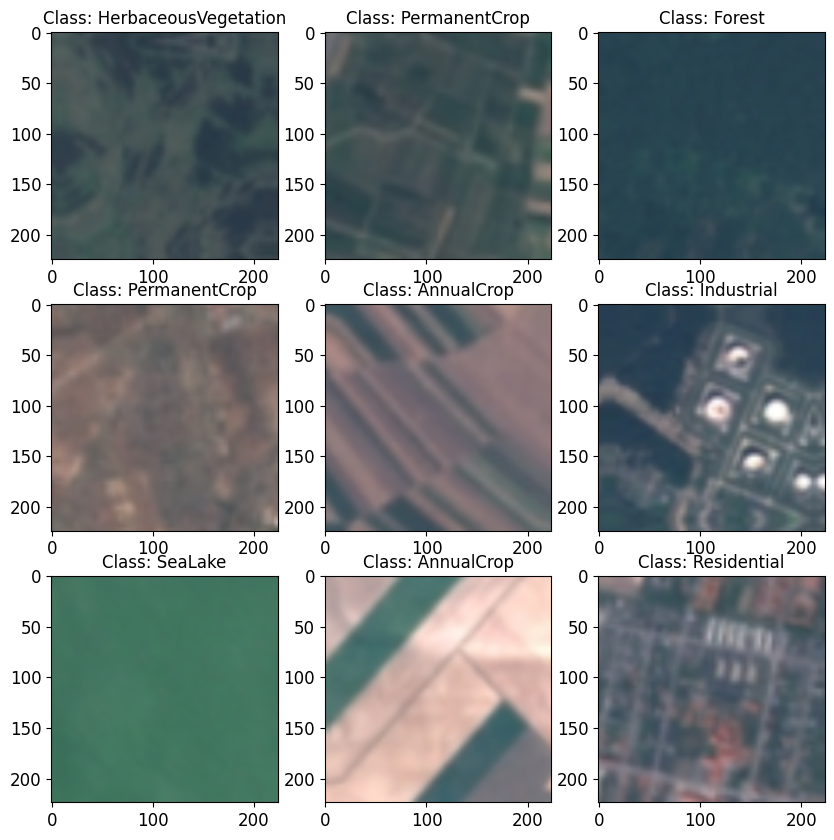

In [21]:
# augmentation 결과 확인 
batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(augment_preprocess)).batch(batch_size).prefetch(1)
train_set = train_set_raw.map(augment_preprocess)

plt.figure(figsize=(10, 10))
index = 0
for image, label in train_set.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))

plt.show()

Epoch 1/40
632/632 [==============================] - 65s 79ms/step - loss: 0.3912 - accuracy: 0.8736 - val_loss: 0.8246 - val_accuracy: 0.7403
Epoch 2/40
632/632 [==============================] - 49s 78ms/step - loss: 0.1750 - accuracy: 0.9424 - val_loss: 3.1309 - val_accuracy: 0.4422
Epoch 3/40
632/632 [==============================] - 49s 78ms/step - loss: 0.1289 - accuracy: 0.9574 - val_loss: 2.5045 - val_accuracy: 0.4606
Epoch 4/40
632/632 [==============================] - 49s 77ms/step - loss: 0.1079 - accuracy: 0.9636 - val_loss: 5.5152 - val_accuracy: 0.2133
Epoch 5/40
632/632 [==============================] - 49s 77ms/step - loss: 0.0893 - accuracy: 0.9698 - val_loss: 4.8886 - val_accuracy: 0.2691
Epoch 6/40
632/632 [==============================] - 49s 77ms/step - loss: 0.0823 - accuracy: 0.9734 - val_loss: 6.3171 - val_accuracy: 0.2569
Epoch 7/40
632/632 [==============================] - 49s 77ms/step - loss: 0.0691 - accuracy: 0.9773 - val_loss: 4.5614 - val_accuracy:

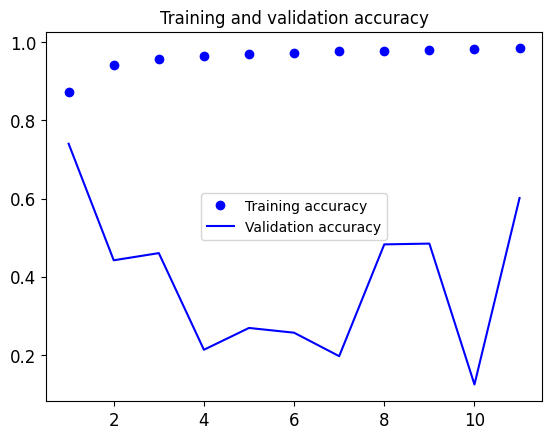

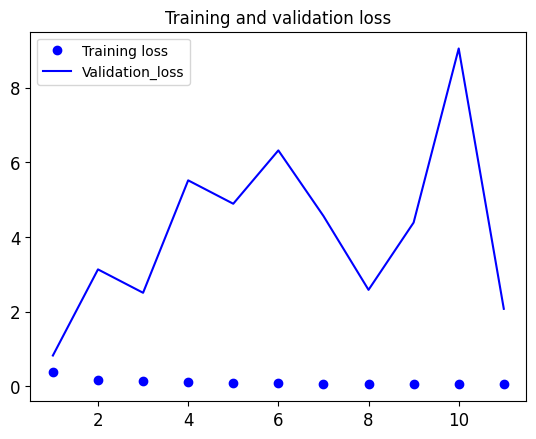

85/85 [==============================] - 2s 19ms/step - loss: 0.8258 - accuracy: 0.7381
테스트 정확도 : 73.815%
85/85 [==============================] - 2s 15ms/step


In [22]:
# 모델 적용을 위해 Input_size 수정한 ver
def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    resized_image = tf.squeeze(resized_image)  # 차원 축소
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

# 데이터 증강을 포함한 전처리 함수 정의 (모델 적용을 위해 Input_size 수정한 ver)
def augment_preprocess(image, label):
    augmented_image = data_augmentation(image)
    resized_image = tf.image.resize(augmented_image, [224, 224])
    normalized_image = resized_image / 255.0
    return normalized_image, label

data_augmentation = keras.Sequential(
    [
        layers.Conv2D(3, 3, input_shape=(224, 224, 3)),  # 입력 형태 설정
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

base_model= keras.applications.xception.Xception(weights="imagenet", include_top=False)
# fine-tuning
for layer in base_model.layers:
   layer.trainable = True

# inputs = keras.Input(shape=(None, None, 3)) 
inputs = keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs) # data augmentation 적용
x = keras.applications.xception.preprocess_input(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(n_classes, activation="softmax")(x)  


model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True, weight_decay=0.001)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics=["accuracy"])

MODEL_SAVE_PATH = "Xception_with_data_augmentation.keras"
EPOCHS = 40

early_stopping_cb=keras.callbacks.EarlyStopping(patience = 10) # Early_Stopping
callbacks = [
    early_stopping_cb, # Early_Stopping
    keras.callbacks.ModelCheckpoint( # Checkpoint
        filepath = MODEL_SAVE_PATH,
        save_best_only = True,
        monitor = "val_loss"
    )
]

model2_history = model.fit(train_set, epochs=EPOCHS, 
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = callbacks
                    )

show_plot(model2_history) # history graph
model2_test_loss, model2_test_acc = model_test(MODEL_SAVE_PATH, test_set) # test dataset에 대한 evaluation 결과

start = time.time()
model.predict(test_set)
end = time.time()
model2_predict_time = end - start # prediction_time

eurosat_results.loc["Xception_with_data_augmentation"] = (model2_test_acc, model2_test_loss, model2_predict_time) 

# (3) 1-(2)에서 hyper parameter 변형
- 기존
  - epochs = 40
  - learning_rate = 0.01
  - batch_size = 32

Epoch 1/5
632/632 [==============================] - 67s 81ms/step - loss: 0.5951 - accuracy: 0.8278 - val_loss: 13.4121 - val_accuracy: 0.0918
Epoch 2/5
632/632 [==============================] - 50s 80ms/step - loss: 0.3992 - accuracy: 0.8817 - val_loss: 2.9319 - val_accuracy: 0.2106
Epoch 3/5
632/632 [==============================] - 50s 79ms/step - loss: 0.2895 - accuracy: 0.9125 - val_loss: 4.3848 - val_accuracy: 0.0945
Epoch 4/5
632/632 [==============================] - 51s 80ms/step - loss: 0.2456 - accuracy: 0.9273 - val_loss: 2.7379 - val_accuracy: 0.2741
Epoch 5/5
632/632 [==============================] - 51s 80ms/step - loss: 0.2295 - accuracy: 0.9295 - val_loss: 2.1849 - val_accuracy: 0.4655


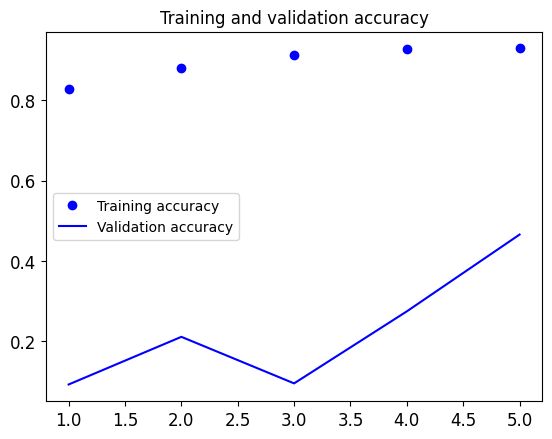

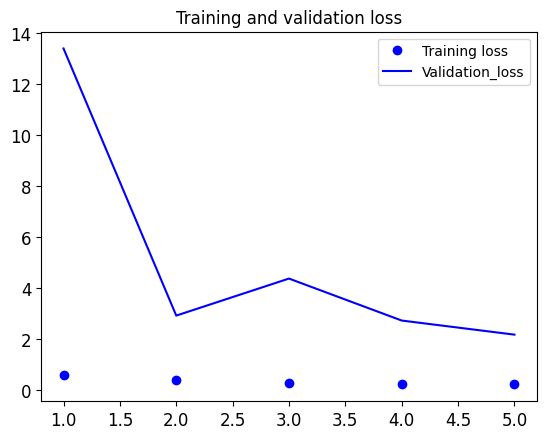

85/85 [==============================] - 2s 17ms/step - loss: 2.2763 - accuracy: 0.4474
테스트 정확도 : 44.741%


In [23]:
# 하이퍼 파라미터 변형 (learning_rate, EPOCHS)
EPOCHS = 5
lr = 0.1

train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

base_model= keras.applications.xception.Xception(weights="imagenet", include_top=False)
# 마지막에서 네번째 층까지 모든 층 동결하기 
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate= lr, momentum=0.9, nesterov=True, weight_decay=0.001)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics=["accuracy"])

MODEL_SAVE_PATH = "Xception_Xception_change_hyperparameters.keras"

callbacks = [
    # early_stopping_cb, # Early_Stopping
    keras.callbacks.ModelCheckpoint( # Checkpoint
        filepath = MODEL_SAVE_PATH,
        save_best_only = True,
        monitor = "val_loss"
    )
]

model3_history = model.fit(train_set, epochs=EPOCHS, 
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = callbacks
                    )

show_plot(model3_history) # history graph
model3_test_loss, model3_test_acc = model_test(MODEL_SAVE_PATH, test_set) # test dataset에 대한 evaluation 결과

Epoch 1/5
632/632 [==============================] - 67s 81ms/step - loss: 0.2083 - accuracy: 0.9350 - val_loss: 0.1266 - val_accuracy: 0.9613
Epoch 2/5
632/632 [==============================] - 50s 80ms/step - loss: 0.2000 - accuracy: 0.9373 - val_loss: 0.1228 - val_accuracy: 0.9628
Epoch 3/5
632/632 [==============================] - 50s 80ms/step - loss: 0.2074 - accuracy: 0.9359 - val_loss: 0.1208 - val_accuracy: 0.9638
Epoch 4/5
632/632 [==============================] - 51s 80ms/step - loss: 0.1962 - accuracy: 0.9389 - val_loss: 0.1185 - val_accuracy: 0.9655
Epoch 5/5
632/632 [==============================] - 51s 80ms/step - loss: 0.1858 - accuracy: 0.9412 - val_loss: 0.1183 - val_accuracy: 0.9648


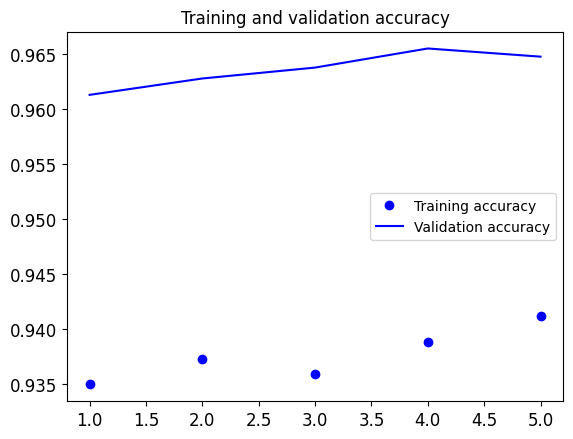

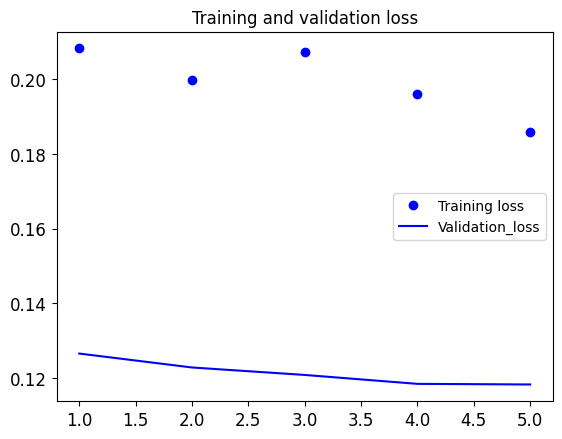

85/85 [==============================] - 2s 18ms/step - loss: 0.1374 - accuracy: 0.9570
테스트 정확도 : 95.704%


In [24]:
# 하이퍼 파라미터 변형 (learning_rate, EPOCHS)
EPOCHS = 5
lr = 1e-5

train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

base_model= keras.applications.xception.Xception(weights="imagenet", include_top=False)
# 마지막에서 네번째 층까지 모든 층 동결하기 
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate= lr, momentum=0.9, nesterov=True, weight_decay=0.001)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics=["accuracy"])

MODEL_SAVE_PATH = "Xception_Xception_change_hyperparameters.keras"

callbacks = [
    # early_stopping_cb, # Early_Stopping
    keras.callbacks.ModelCheckpoint( # Checkpoint
        filepath = MODEL_SAVE_PATH,
        save_best_only = True,
        monitor = "val_loss"
    )
]

model3_history = model.fit(train_set, epochs=EPOCHS, 
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = callbacks
                    )

show_plot(model3_history) # history graph
model3_test_loss, model3_test_acc = model_test(MODEL_SAVE_PATH, test_set) # test dataset에 대한 evaluation 결과

Epoch 1/40
632/632 [==============================] - 66s 81ms/step - loss: 0.1852 - accuracy: 0.9420 - val_loss: 0.1115 - val_accuracy: 0.9665
Epoch 2/40
632/632 [==============================] - 50s 80ms/step - loss: 0.1877 - accuracy: 0.9425 - val_loss: 0.1092 - val_accuracy: 0.9673
Epoch 3/40
632/632 [==============================] - 50s 80ms/step - loss: 0.1749 - accuracy: 0.9441 - val_loss: 0.1086 - val_accuracy: 0.9673
Epoch 4/40
632/632 [==============================] - 50s 80ms/step - loss: 0.1734 - accuracy: 0.9474 - val_loss: 0.1066 - val_accuracy: 0.9688
Epoch 5/40
632/632 [==============================] - 50s 80ms/step - loss: 0.1784 - accuracy: 0.9430 - val_loss: 0.1063 - val_accuracy: 0.9685
Epoch 6/40
632/632 [==============================] - 50s 80ms/step - loss: 0.1809 - accuracy: 0.9432 - val_loss: 0.1039 - val_accuracy: 0.9692
Epoch 7/40
632/632 [==============================] - 50s 79ms/step - loss: 0.1725 - accuracy: 0.9460 - val_loss: 0.1041 - val_accuracy:

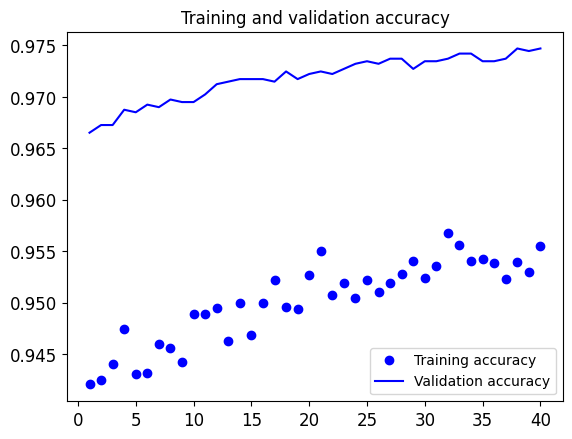

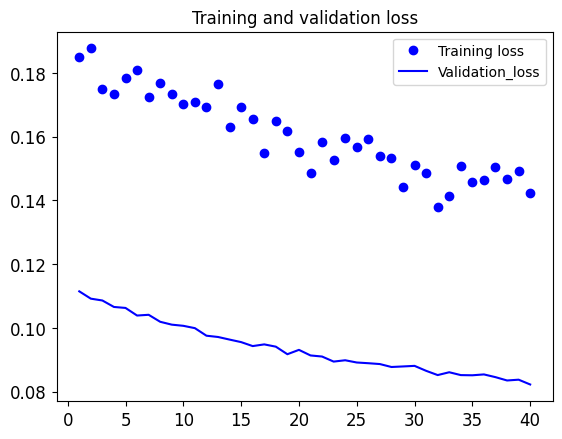

85/85 [==============================] - 2s 18ms/step - loss: 0.1005 - accuracy: 0.9678
테스트 정확도 : 96.778%
85/85 [==============================] - 2s 15ms/step


In [26]:
# 하이퍼 파라미터 변형 (learning_rate, EPOCHS)
EPOCHS = 40
lr = 1e-5

train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

base_model= keras.applications.xception.Xception(weights="imagenet", include_top=False)
# 마지막에서 네번째 층까지 모든 층 동결하기 
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate= lr, momentum=0.9, nesterov=True, weight_decay=0.001)
model.compile(loss = "sparse_categorical_crossentropy", 
              optimizer = optimizer,
              metrics=["accuracy"])

MODEL_SAVE_PATH = "Xception_Xception_change_hyperparameters.keras"

early_stopping_cb=keras.callbacks.EarlyStopping(patience = 10) # Early_Stopping
callbacks = [
    early_stopping_cb, # Early_Stopping
    keras.callbacks.ModelCheckpoint( # Checkpoint
        filepath = MODEL_SAVE_PATH,
        save_best_only = True,
        monitor = "val_loss"
    )
]

model3_history = model.fit(train_set, epochs=EPOCHS, 
                    validation_data=valid_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    callbacks = callbacks
                    )

show_plot(model3_history) # history graph
model3_test_loss, model3_test_acc = model_test(MODEL_SAVE_PATH,test_set) # test dataset에 대한 evaluation 결과

start = time.time()
model.predict(test_set)
end = time.time()
model3_predict_time = end - start # prediction_time

eurosat_results.loc["Xception_change_hp"] = (model3_test_acc, model3_test_loss, model3_predict_time) 

***

# 각 evaluation 결과 확인

In [27]:
eurosat_results

,test_acc,test_loss,pred_time
Xception_without_data_augmentation,0.981481,0.067447,2.833326
Xception_with_data_augmentation,0.738148,0.82576,2.086338
Xception_change_hp,0.967778,0.100466,2.119271


[Text(0, 0, 'Xception_without_data_augmentation'),
 Text(1, 0, 'Xception_with_data_augmentation'),
 Text(2, 0, 'Xception_change_hp')]

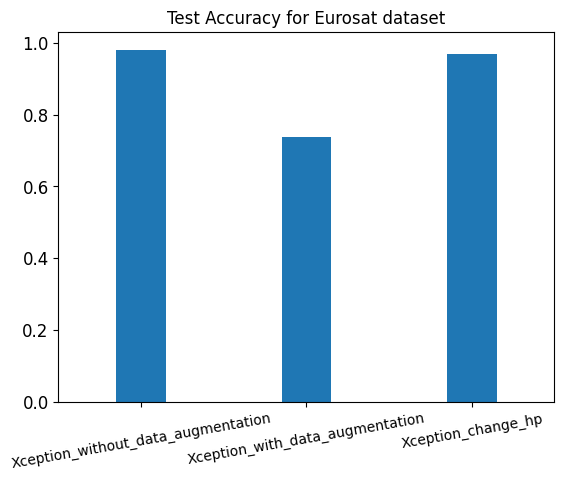

In [31]:
models = list(eurosat_results.index)
test_accs = list(eurosat_results["test_acc"])
plt.bar(range(len((models))), test_accs, width = 0.3)

plt.xlim(-0.5, 2.5)
plt.title('Test Accuracy for Eurosat dataset')

ax = plt.subplot()
ax.set_xticks([0,1,2])
ax.set_xticklabels(models, fontsize = 10, rotation = 10)

[Text(0, 0, 'Xception_without_data_augmentation'),
 Text(1, 0, 'Xception_with_data_augmentation'),
 Text(2, 0, 'Xception_change_hp')]

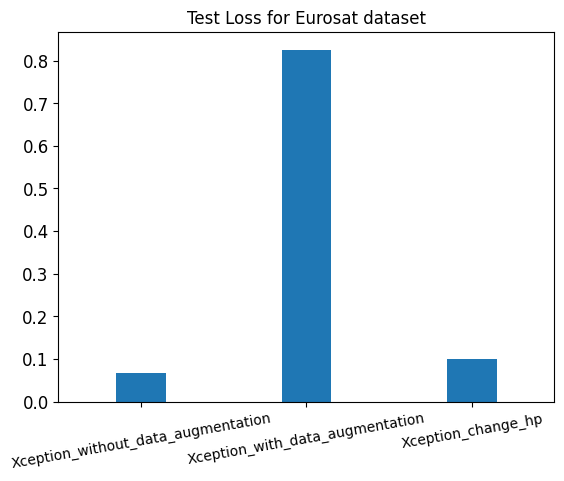

In [32]:
test_losss = list(eurosat_results["test_loss"])
plt.bar(range(len((models))), test_losss, width = 0.3)

plt.xlim(-0.5, 2.5)
plt.title('Test Loss for Eurosat dataset')

ax = plt.subplot()
ax.set_xticks([0,1,2])
ax.set_xticklabels(models, fontsize = 10, rotation = 10)

[Text(0, 0, 'Xception_without_data_augmentation'),
 Text(1, 0, 'Xception_with_data_augmentation'),
 Text(2, 0, 'Xception_change_hp')]

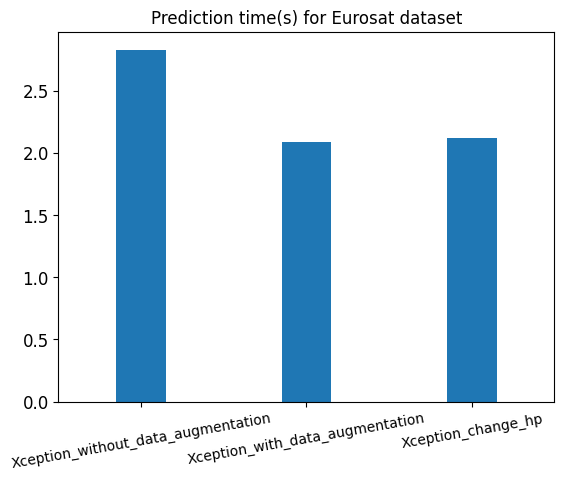

In [33]:
pred_times = list(eurosat_results["pred_time"])
plt.bar(range(len((models))), pred_times, width = 0.3)

plt.xlim(-0.5, 2.5)
plt.title('Prediction time(s) for Eurosat dataset')

ax = plt.subplot()
ax.set_xticks([0,1,2])
ax.set_xticklabels(models, fontsize = 10, rotation = 10)